# Import Necessary Libraries and  loaad the dataset

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  
df[text_column] = df[text_column].astype(str).fillna('')

# Map offensive (1) to hate speech (0)
df['class'] = df['class'].map({0: 0, 1: 0, 2: 1})

# Initialize the TF-IDF Vectorizer and  Handle Imbalanced Data with SMOTE

In [18]:
# Split the data into features (X) and labels (y)
X = df[text_column]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4000)  # Adjust max_features as needed

# Fit and transform the training data, then transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix for training data:", X_train_tfidf.shape)
print("Shape of TF-IDF matrix for test data:", X_test_tfidf.shape)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

Shape of TF-IDF matrix for training data: (19826, 4000)
Shape of TF-IDF matrix for test data: (4957, 4000)


# Define Models and Pipelines

In [19]:
# Define the models
models = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'NaiveBayes': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier()
}

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [1, 0.1, 0.01, 0.001],
        'clf__kernel': ['linear', 'rbf']
    },
    'NaiveBayes': {
        'clf__alpha': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1, 10, 100]
    },
    'DecisionTree': {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
}

# Define pipelines
pipelines = {
    model_name: ImbPipeline([
        ('tfidf', TfidfVectorizer(max_features=4000)),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    for model_name, model in models.items()
}

# Hyperparameter Tuning

In [20]:
# Hyperparameter tuning
best_estimators = {}
for model_name, pipeline in pipelines.items():
    random_search = RandomizedSearchCV(pipeline, param_grids[model_name], n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimators[model_name] = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RandomForest: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVM: {'clf__kernel': 'rbf', 'clf__gamma': 1, 'clf__C': 10}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for NaiveBayes: {'clf__alpha': 1.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for LogisticRegression: {'clf__C': 10}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for DecisionTree: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 30}


# Model Evaluation and Visualization

RandomForest - Accuracy: 0.9380673794633851
                 precision    recall  f1-score   support

    Hate Speech       0.97      0.96      0.96      4122
Non-Hate Speech       0.80      0.85      0.82       835

       accuracy                           0.94      4957
      macro avg       0.88      0.90      0.89      4957
   weighted avg       0.94      0.94      0.94      4957



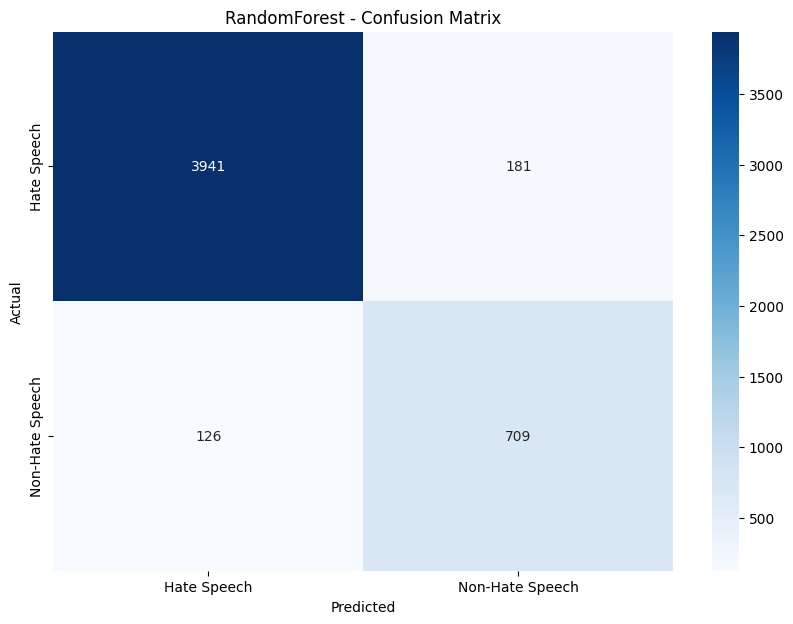

SVM - Accuracy: 0.937462174702441
                 precision    recall  f1-score   support

    Hate Speech       0.96      0.97      0.96      4122
Non-Hate Speech       0.82      0.80      0.81       835

       accuracy                           0.94      4957
      macro avg       0.89      0.88      0.89      4957
   weighted avg       0.94      0.94      0.94      4957



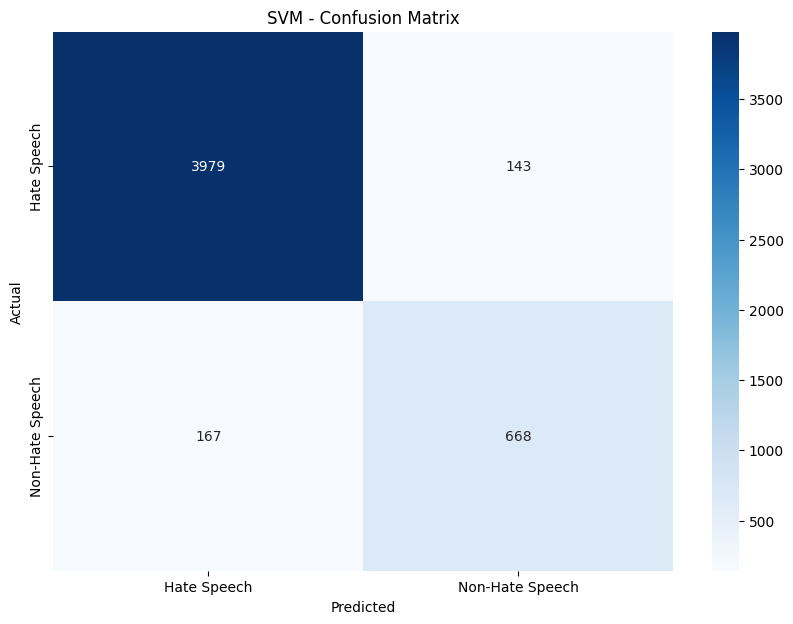

NaiveBayes - Accuracy: 0.9136574541053056
                 precision    recall  f1-score   support

    Hate Speech       0.96      0.93      0.95      4122
Non-Hate Speech       0.71      0.83      0.76       835

       accuracy                           0.91      4957
      macro avg       0.84      0.88      0.86      4957
   weighted avg       0.92      0.91      0.92      4957



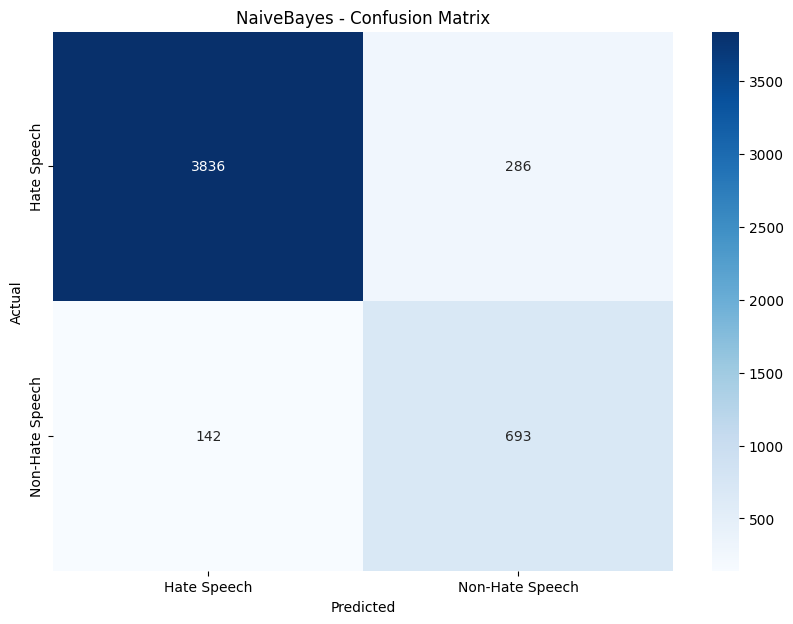

LogisticRegression - Accuracy: 0.9382691143836999
                 precision    recall  f1-score   support

    Hate Speech       0.98      0.94      0.96      4122
Non-Hate Speech       0.77      0.91      0.83       835

       accuracy                           0.94      4957
      macro avg       0.87      0.93      0.90      4957
   weighted avg       0.94      0.94      0.94      4957



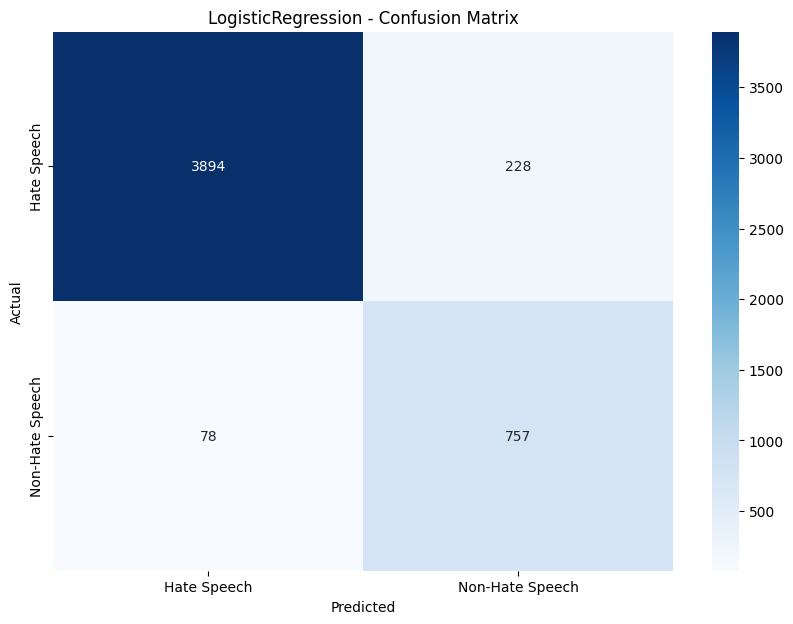

DecisionTree - Accuracy: 0.9295945128101675
                 precision    recall  f1-score   support

    Hate Speech       0.99      0.93      0.96      4122
Non-Hate Speech       0.72      0.95      0.82       835

       accuracy                           0.93      4957
      macro avg       0.85      0.94      0.89      4957
   weighted avg       0.94      0.93      0.93      4957



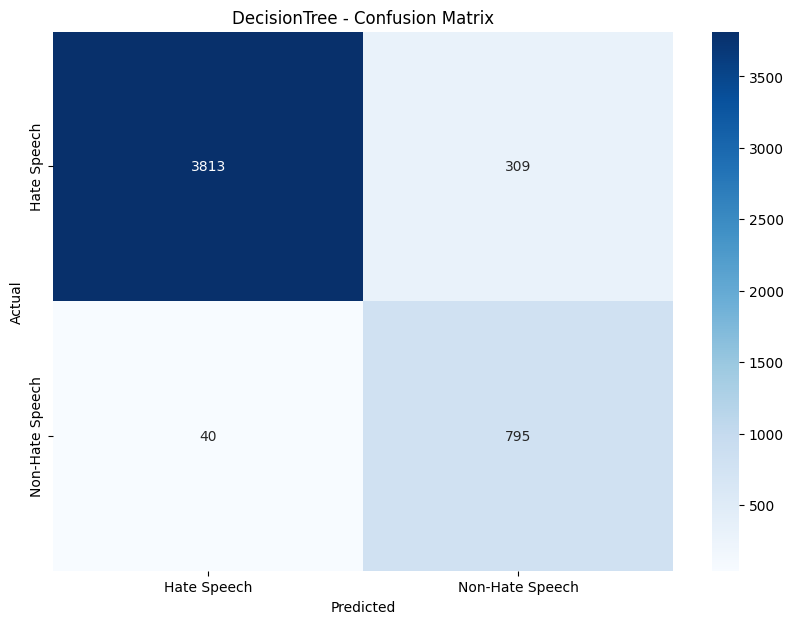

In [21]:
# Evaluate the models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} - Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred, target_names=['Hate Speech', 'Non-Hate Speech']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Non-Hate Speech'], yticklabels=['Hate Speech', 'Non-Hate Speech'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'{model_name}_confusion_matrix.png')  # Save the plot as an image
    plt.show()

# Evaluate each model
for model_name, model in best_estimators.items():
    evaluate_model(model, X_test, y_test, model_name)


# Save the Best Model

In [22]:
# Determine the best model based on accuracy
best_model_name = max(best_estimators, key=lambda name: accuracy_score(y_test, best_estimators[name].predict(X_test)))
best_model = best_estimators[best_model_name]

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f'The best model is {best_model_name} and it has been saved as best_model.pkl')


The best model is LogisticRegression and it has been saved as best_model.pkl


# Loading the original dataset to see predictions

In [28]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f'The best model is {best_model_name} and it has been saved as best_model.pkl')

# Load the new data
new_df = pd.read_csv('labeled_data.csv')
new_text_column = 'tweet'
new_df[new_text_column] = new_df[new_text_column].astype(str).fillna('')
new_X = new_df[new_text_column]

# Predict using the best model pipeline (no need for explicit transformation)
new_predictions = best_model.predict(new_X)

# Add predictions to the dataframe
new_df['predictions'] = new_predictions

# Save the predictions to a CSV file
new_df.to_csv('new_data_with_predictions.csv', index=False)

# Print the predictions
print(new_df[['tweet', 'predictions']])

The best model is LogisticRegression and it has been saved as best_model.pkl
                                                   tweet  predictions
0      !!! RT @mayasolovely: As a woman you shouldn't...            1
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...            0
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...            0
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...            0
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...            0
...                                                  ...          ...
24778  you's a muthaf***in lie &#8220;@LifeAsKing: @2...            1
24779  you've gone and broke the wrong heart baby, an...            1
24780  young buck wanna eat!!.. dat nigguh like I ain...            0
24781              youu got wild bitches tellin you lies            0
24782  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...            1

[24783 rows x 2 columns]
